In [24]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


## Keeping everything else (bs, LR, w_recon, w_sup, prior type etc.) the same we just varied w_kld = 5,10,15,20,25 

In [25]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
#from common import notebook_utils
from common import utils
#from common.notebook_utils import *
from common import notebook_utils as nbutils
from common.utils import CenteredNorm
from gnncsvae_experiment import GNNCSVAEExperiment
from common.ops import reparametrize
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [4]:
# these two will be used any time we load a saved checkppoint

PROJECT_ROOT = r"D:\Saarbrucken\EDA_Research\vae-disentanglement"
datapath = os.path.join(PROJECT_ROOT, "datasets")
os.environ['DISENTANGLEMENT_LIB_DATA'] = datapath

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "w_sup_reg", "w_cov_loss", 
                                         "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms", "use_loss_weights",
                                        "controlled_capacity_increase", "iterations_c", "max_capacity", "dset_name", 
                                         "num_indept_nodes", "prior_type"
                                        ])

ExpParams = dict(
        in_channels=-1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=None,
        datapath=datapath,
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)

# KLD = 5

In [5]:
# load the learned model here

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "pendulum_switch_kld_test", "pendulum_sw229wkld5.ckpt")
z_dim = 1
channels = 3
l_dim = 6
num_nodes = 6
num_indept_nodes = 0
dataset_name = "pendulum_switch"
current_device = torch.device("cuda:0")
prior_type = "gt_based_learnable"

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64, 0.80, 0.15, 1.0, 0, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset_name}.pkl"),
        ['aux_classification'], False,
        False, 0, 0, "pendulum", num_indept_nodes, prior_type
)

ExpParams['channels'] = channels

# load model
print("Loading model")
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)


Loading model
Posterior mat:  tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1.]])
Prior mat:  [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0.]]
prior:  gt_based_learnable
GNNBasedConceptStructuredVAE Model Initialized


In [6]:
print("Loading dataset: ", dataset_name)
dataset = nbutils.get_configured_dataset(dataset_name)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = True, drop_last=True)

Loading dataset:  pendulum_switch


# Learned Prior, Posterior activations

In [7]:
# get learned prior activations
prior_mu_batches, gt_batches = nbutils.get_prior_mus_given_gt_labels(vae_model, sample_loader, current_device, batches=None)

# get activations generated by the images in dataset
mu_batches, label_batches = nbutils.csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = None)

print("Learned Prior shape:", prior_mu_batches.shape)
print("GT labels shape: ", gt_batches.shape)
print("Learend posterior shape: ", mu_batches.shape)


Learned Prior shape: (14592, 6)
GT labels shape:  (14592, 6)
Learend posterior shape:  (14592, 6, 1)


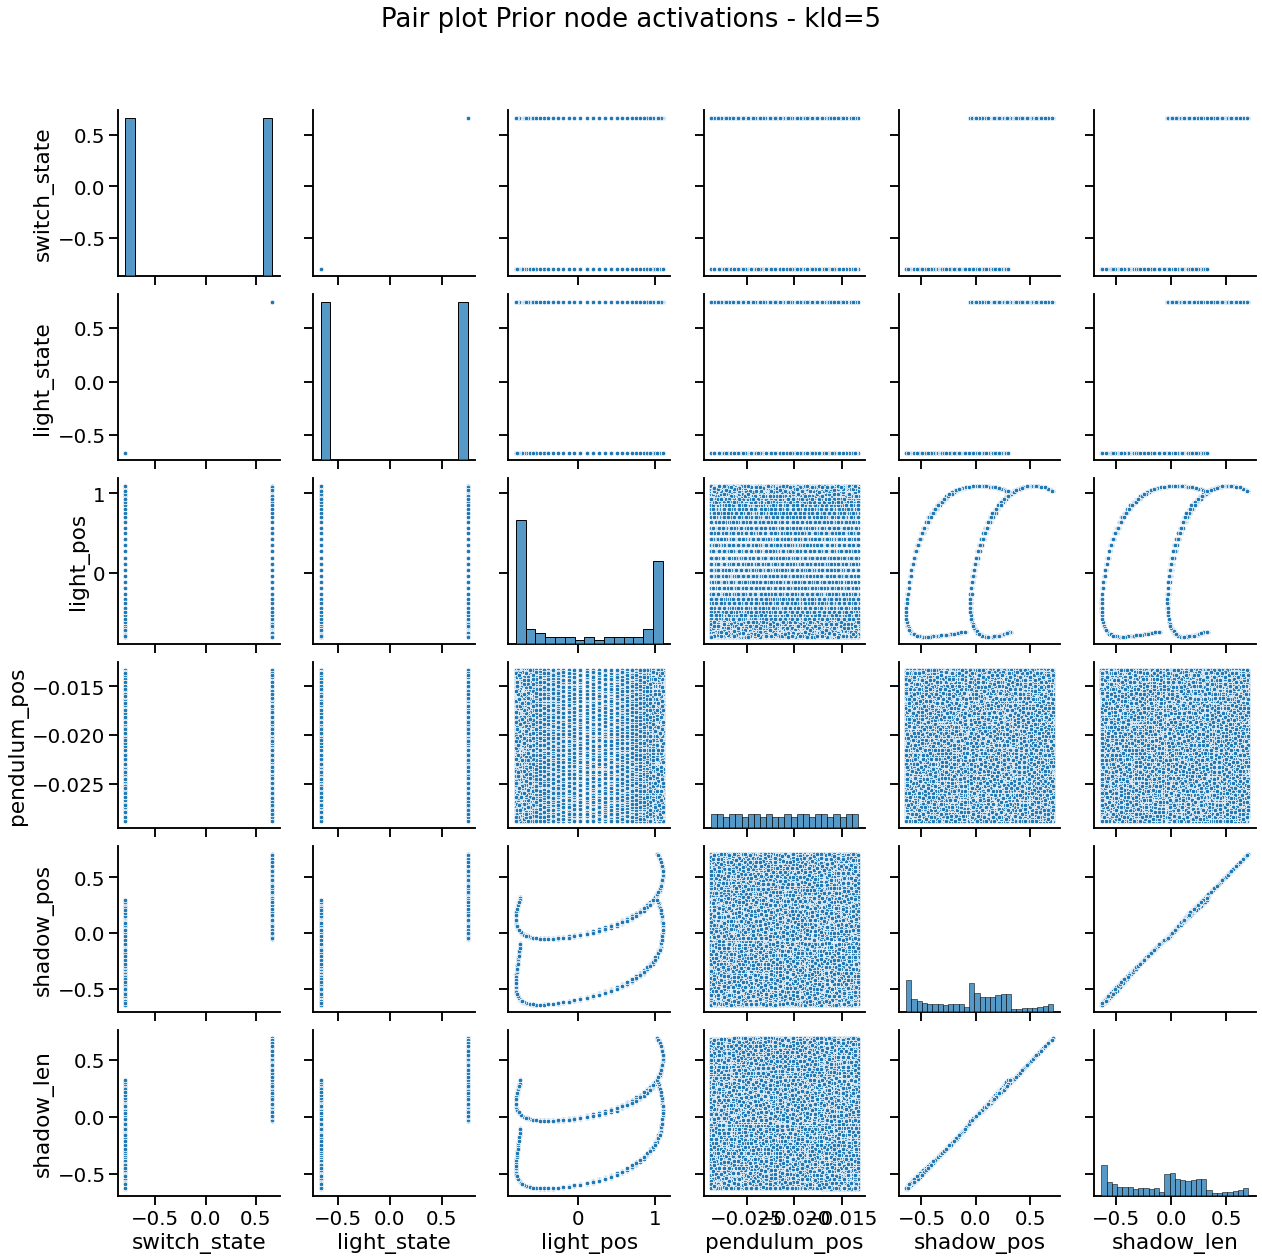

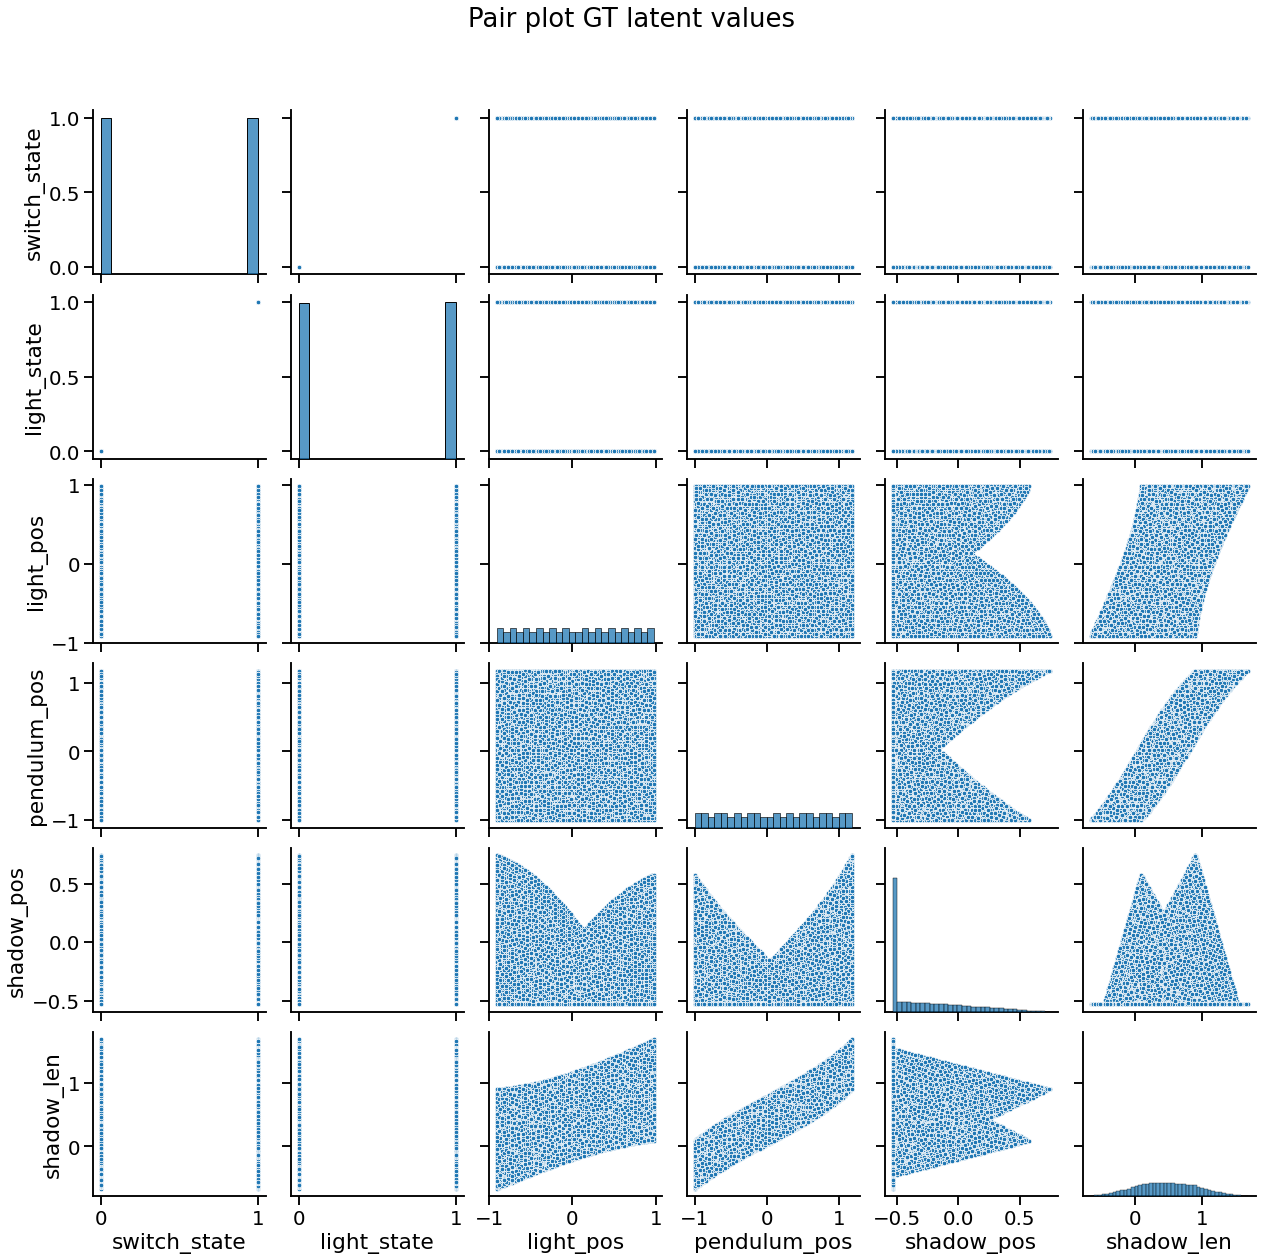

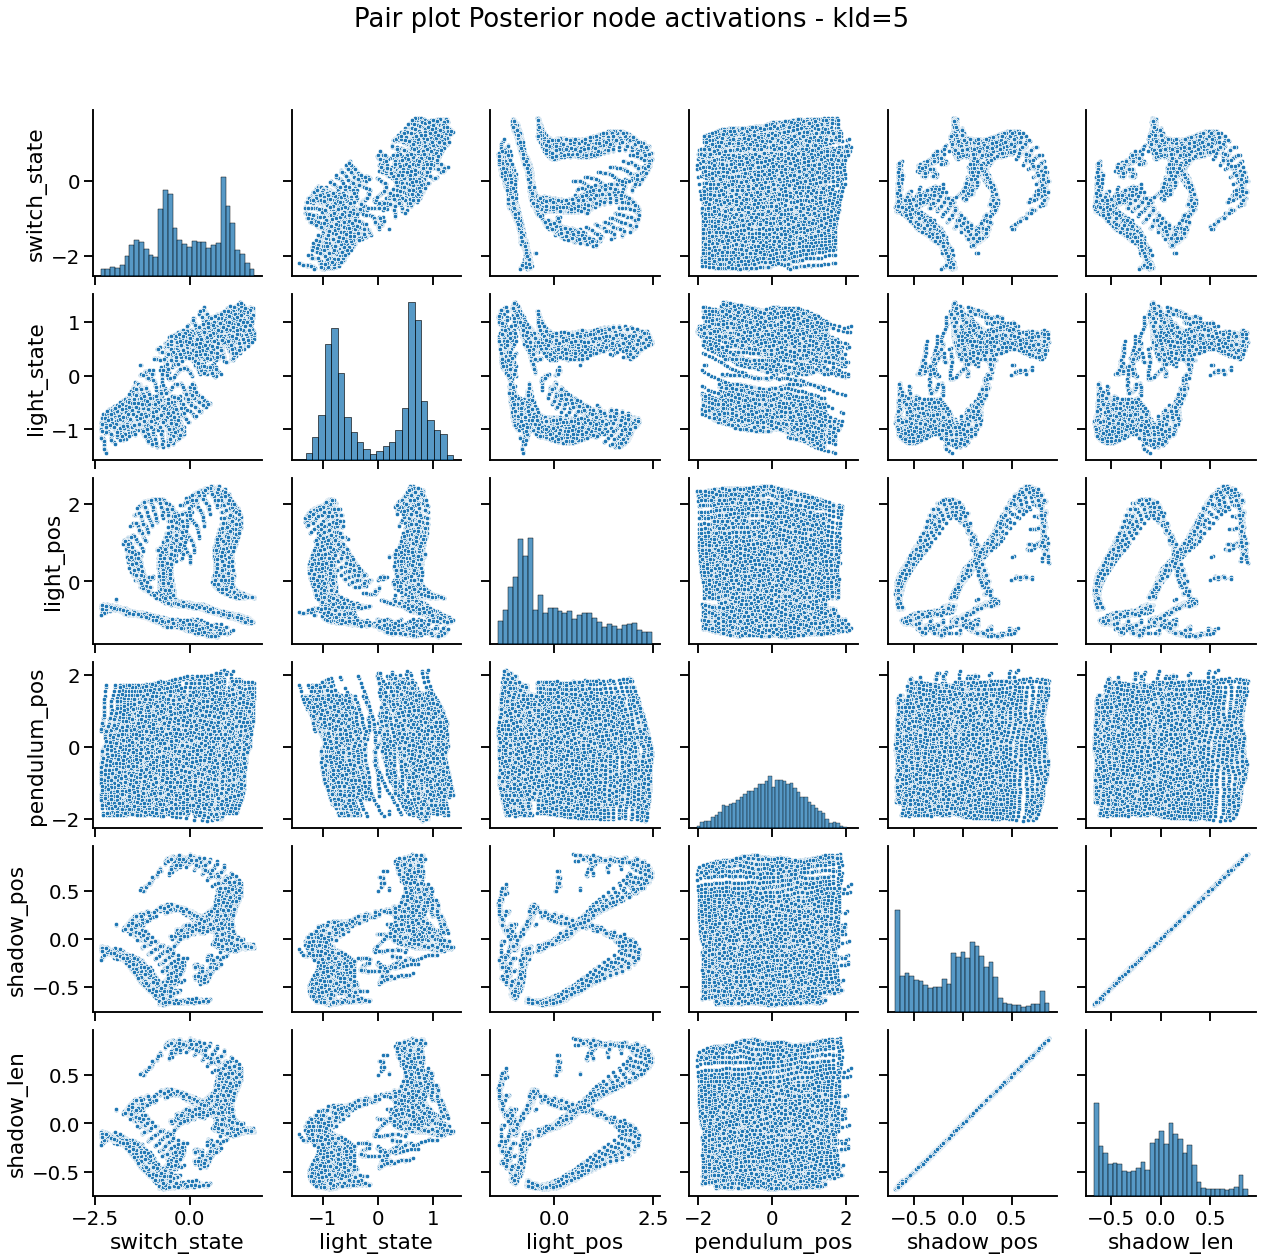

In [16]:
# plot learned prior activations
cols = ["switch_state","light_state","light_pos","pendulum_pos","shadow_pos","shadow_len"]
activations_df = pd.DataFrame(prior_mu_batches, columns=cols)
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Prior node activations - kld=5")
sns_plot.fig.subplots_adjust(top=0.9)

# plot of relationships b/w actual Latent  gt values
activations_df = pd.DataFrame(gt_batches, columns=cols)
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot GT latent values")
sns_plot.fig.subplots_adjust(top=0.9)

# plot learned posterior activations
# suppress the feat_dim dimension from (b,V,feat_dim) assuming it has only 1-dim
activations = mu_batches.squeeze(2)
activations_df = pd.DataFrame(activations, columns=cols)
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Posterior node activations - kld=5")
sns_plot.fig.subplots_adjust(top=0.9)


In [19]:
# Calculate GT covariance and learned prior covariances

gt_cov = pd.DataFrame(np.cov(gt_batches.T), cols, cols)
print("Ground Truth Latent Cov")
gt_cov

Ground Truth Latent Cov


,switch_state,light_state,light_pos,pendulum_pos,shadow_pos,shadow_len
switch_state,0.250017,0.250017,-0.000005,0.000071,0.000069,0.000031
light_state,0.250017,0.250017,-0.000005,0.000071,0.000069,0.000031
light_pos,-0.000005,-0.000005,0.303752,0.000027,-0.012913,0.127448
pendulum_pos,0.000071,0.000071,0.000027,0.407811,0.021856,0.251101
shadow_pos,0.000069,0.000069,-0.012913,0.021856,0.099648,0.008843
shadow_len,0.000031,0.000031,0.127448,0.251101,0.008843,0.208861


In [22]:
prior_cov = pd.DataFrame(np.cov(prior_mu_batches.T), cols, cols)
print("Learned prior cov")
prior_cov

Learned prior cov


,switch_state,light_state,light_pos,pendulum_pos,shadow_pos,shadow_len
switch_state,5.341262e-01,5.146237e-01,-3.396364e-05,-7.363484e-07,0.197311,0.195131
light_state,5.146237e-01,4.958333e-01,-3.272353e-05,-7.094622e-07,0.190106,0.188006
light_pos,-3.396364e-05,-3.272353e-05,6.413066e-01,-1.855040e-07,0.126219,0.123199
pendulum_pos,-7.363484e-07,-7.094622e-07,-1.855040e-07,2.054329e-05,-0.000009,-0.000008
shadow_pos,1.973106e-01,1.901062e-01,1.262191e-01,-8.731852e-06,0.135911,0.134253
shadow_len,1.951311e-01,1.880063e-01,1.231985e-01,-7.812070e-06,0.134253,0.132739


In [23]:
posterior_cov = pd.DataFrame(np.cov(mu_batches.squeeze(2).T), cols, cols)
print("Learned posterior cov")
posterior_cov

Learned posterior cov


,switch_state,light_state,light_pos,pendulum_pos,shadow_pos,shadow_len
switch_state,0.896613,0.597792,0.065113,0.093166,0.132446,0.133020
light_state,0.597792,0.584550,-0.066468,-0.056353,0.198349,0.197971
light_pos,0.065113,-0.066468,1.009099,-0.053786,0.144838,0.141398
pendulum_pos,0.093166,-0.056353,-0.053786,0.676389,0.007471,0.008075
shadow_pos,0.132446,0.198349,0.144838,0.007471,0.145873,0.144590
shadow_len,0.133020,0.197971,0.141398,0.008075,0.144590,0.143358


In [ ]:
images, labels = next(sample_loader.__iter__())

Visualizing latent space from -3.95 to 2.15, with center at 3.05


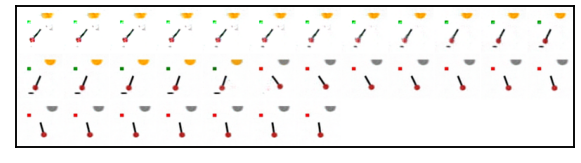

In [15]:
ref_img = images[20].unsqueeze(0).to(current_device)

traversed_images = nbutils.csvaegnn_do_latent_traversal_scatter(vae_model, ref_img, limit=3, inter=1/5, 
                                        node_to_explore=2, dim_to_explore=0, mode='relative', 
                                        lb=None, ub=None, fix_dim=None, fix_val=None)

traversed_images_stacked = torch.stack([t_img.squeeze(0) for t_img in traversed_images], dim=0)
img_grid = vutils.make_grid(traversed_images_stacked, normalize=True, nrow=12, value_range=(0.0,1.0), pad_value=1.0)
nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

In [8]:
(33660/54000)*100

62.33333333333333

In [9]:
33660/12

2805.0

In [ ]:
2500